In [1]:
import os
import re
import numpy as np

from pathlib import Path

import pandas as pd
import torch
import evaluate

from torch import nn
from tqdm.notebook import tqdm
from tokenizers import Tokenizer
from tokenizers import normalizers
from tokenizers import pre_tokenizers
from tokenizers.models import WordLevel, WordPiece
from tokenizers.processors import TemplateProcessing


from torch.utils.data import DataLoader, Dataset, Subset

from tokenizers.normalizers import NFC, StripAccents, Strip, Lowercase
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import WordLevelTrainer, WordPieceTrainer

from sklearn.model_selection import train_test_split

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

# Dataset

## Setup

In [3]:
data_dir = os.path.join(os.curdir, "data")
data_path = os.path.join(data_dir, "ara_eng.txt")


data = pd.read_csv(data_path, sep="\t", names=["target", "source"])

In [4]:
data

,target,source
0,Hi.,مرحبًا.
1,Run!,اركض!
2,Help!,النجدة!
3,Jump!,اقفز!
4,Stop!,قف!
...,...,...
24633,rising voices promoting a more linguistically ...,شاركنا تحدي ابداع ميم بلغتك الام تعزيزا للتنوع...
24634,following last year s successful campaign we i...,استكمالا لنجاح حملة العام السابق ندعوكم للمشار...
24635,during last year s challenge we also met langu...,تعرفنا خلال تحدي العام الماضي على ابطال لغويين...
24636,to take part just follow the simple steps outl...,للمشاركة في التحدي اتبع الخطوات الموضحة على ال...


In [5]:
print(f"Total samples = {len(data)}")

Total samples = 24638


## Preprocessing

In [6]:
punc_re = re.compile(r"""[!"#$%&\'()*+,-./:;<=>?@[\\\]^_`{|}~،؟…«“\":\"…”]""")
def remove_punctation(text: str) -> str:
    return punc_re.sub(repl="", string=text)


diactircs_re = re.compile("[\u064B-\u0652]")
def remove_diactrics(text: str) -> str:
    # TODO: Implement this function using the diactrics_re
    return diactircs_re.sub(repl="", string=text)

def clean_text(text: str) -> str:
    return remove_punctation(remove_diactrics(text))

In [7]:
data["target"] = data["target"].map(clean_text)
data["source"] = data["source"].map(clean_text)

In [8]:
data["target"].duplicated(keep='first').sum()

1821

In [9]:
data = data.copy(deep=True)[~data.duplicated()]

In [10]:
data.shape

(24328, 2)

## Limiting samples by sequence length

In [11]:
data["length"] = data["source"].map(lambda x: len(x.split(" ")))

In [12]:
data.describe()

,length
count,24328.000000
mean,15.176833
std,17.688084
min,1.000000
25%,4.000000
50%,7.000000
75%,20.000000
max,225.000000


In [13]:
# max_len = np.percentile(data["length"], q=95)
max_len = 15
max_len

15

In [14]:
data = data[data["length"] <= max_len]
data.shape

(16977, 3)

In [15]:
train, test = train_test_split(data)

In [16]:
len(train), len(test)

(12732, 4245)

## Tokenization

In [17]:
normalizer = normalizers.Sequence([NFC(), StripAccents(), Lowercase(), Strip()])

In [18]:
post_processor = TemplateProcessing(
    single="[SOS] $A [EOS]",
    special_tokens=[("[SOS]", 2), ("[EOS]", 3)]
)

In [19]:
ar_tokenizer = Tokenizer(model=WordLevel(unk_token="[OOV]"))
en_tokenizer = Tokenizer(model=WordLevel(unk_token="[OOV]"))

In [20]:
pre_tokenizer = pre_tokenizers.Sequence([Whitespace()])

In [21]:
ar_tokenizer.normalizer = normalizer
ar_tokenizer.pre_tokenizer = pre_tokenizer

en_tokenizer.normalizer = normalizer
en_tokenizer.pre_tokenizer = pre_tokenizer

ar_tokenizer.enable_padding(direction='right')
en_tokenizer.enable_padding(direction='right')


ar_tokenizer.post_processor = post_processor
en_tokenizer.post_processor = post_processor

In [22]:
trainer = WordLevelTrainer(vocab_size=200000, show_progress=True, min_frequency=5, 
                           special_tokens=["[PAD]", "[OOV]", "[SOS]", "[EOS]"]
                          )

In [23]:
ar_tokenizer.train_from_iterator(iterator=data["source"].tolist(), trainer=trainer)
en_tokenizer.train_from_iterator(iterator=data["target"].tolist(), trainer=trainer)

In [24]:
ar_tokenizer.get_vocab()

{'كلمة': 1359,
 'بكل': 2373,
 'جماعة': 2921,
 'خوسيه': 2939,
 'السرطان': 2278,
 'حساب': 435,
 'النوافذ': 2817,
 'اعتقال': 379,
 'ألقي': 2199,
 'جميلة': 358,
 'الاقتصاد': 2697,
 'القلعة': 1467,
 'صوتك': 2458,
 'حل': 731,
 'السفارة': 2750,
 'تتعلم': 2385,
 'فمك': 3024,
 'وقتا': 1080,
 'مدينة': 183,
 'موريتانيا': 2548,
 'شاركت': 2062,
 'أحضر': 513,
 'الصاعدة': 1457,
 'عمان': 436,
 'الفلسطيني': 1465,
 'المتعة': 2314,
 'موقع': 54,
 'فعلت': 477,
 'للاحتجاج': 3053,
 'الالاف': 2247,
 'عطلة': 1545,
 'حب': 1732,
 'تغريدات': 2403,
 'ظل': 3002,
 'حدث': 253,
 'معاملة': 1816,
 'الرياسية': 1939,
 'جرح': 2919,
 'المسألة': 1132,
 'الحر': 1928,
 'إنك': 231,
 'لكن': 302,
 'المشاريع': 1471,
 'تملك': 2030,
 'تجاه': 929,
 'أذكر': 830,
 'نظر': 1077,
 'لك': 61,
 'الخريف': 1116,
 'يحدث': 314,
 'بودابست': 2014,
 'بالأمس': 297,
 'الرحلة': 2272,
 'متعب': 1374,
 'وذلك': 2579,
 'بالجلوس': 2841,
 'آكل': 892,
 'حرب': 1314,
 'أقترح': 2631,
 'يرام': 1233,
 'تقرير': 308,
 'ستبدأ': 2973,
 'سليمان': 2058,
 'يحبون': 1083,


In [25]:
en_tokenizer.get_vocab()

{'food': 328,
 'ate': 2020,
 'stupid': 675,
 'peru': 766,
 'translation': 1034,
 'hot': 582,
 'night': 276,
 'true': 549,
 'states': 923,
 'bath': 1629,
 'cats': 1118,
 'probably': 1737,
 'popular': 672,
 'building': 743,
 'chair': 1356,
 'every': 218,
 'noise': 867,
 'impunity': 1895,
 'lina': 1908,
 'light': 586,
 'against': 232,
 'among': 1253,
 'supporting': 2606,
 'more': 89,
 'couple': 1833,
 'carlos': 1640,
 'athens': 2295,
 'sad': 1574,
 'become': 555,
 'licensed': 2147,
 'huge': 2444,
 'named': 1719,
 'doing': 350,
 'didnt': 118,
 'dollars': 1849,
 'historic': 2125,
 'being': 290,
 'ethiopia': 1662,
 'yet': 383,
 'sports': 1326,
 'y': 1613,
 'seven': 2216,
 'forgot': 1064,
 'ill': 81,
 'sopa': 1967,
 'dress': 949,
 'denied': 2073,
 'revolution': 345,
 'massacre': 1225,
 'anniversary': 1254,
 'actually': 1470,
 'nobel': 1550,
 'party': 488,
 'bassel': 1804,
 'play': 215,
 'photo': 54,
 'great': 581,
 'fruit': 1673,
 'diet': 1846,
 'lady': 2145,
 'luck': 2152,
 'mistakes': 2491,

In [26]:
ar_tokenizer.get_vocab_size()

3169

In [27]:
en_tokenizer.get_vocab_size()

2654

## Dataset and DataLoader

In [28]:
class TranslationDataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        self.df = df.sort_values(by="length")
        
        self.src = df["source"].tolist()
        self.trg = df["target"].tolist()
                       
        
    def __getitem__(self, idx):
        source = self.src[idx]
        target = self.trg[idx]
        return (source, target)
        
    def __len__(self):
        return len(self.df)

In [29]:
train_dataset = TranslationDataset(df=train)
test_dataset = TranslationDataset(df=test)

In [30]:
def prepare_batch(batch, ar_tokenizer: Tokenizer, en_tokenizer: Tokenizer):
    ar = list(map(lambda x: x[0], batch))
    en = list(map(lambda x: x[1], batch))
    
    
    ar = ar_tokenizer.encode_batch(ar)
    en = en_tokenizer.encode_batch(en)
    
    
    
    ar_tokens = list(map(lambda x: x.ids, ar))
    ar_mask = list(map(lambda x: x.attention_mask, ar))
    en_tokens = list(map(lambda x: x.ids, en))
    en_mask = list(map(lambda x: x.attention_mask, en))

    
    source = torch.tensor(ar_tokens)
    source_mask = torch.tensor(ar_mask)
    target = torch.tensor(en_tokens)
    target_mask = torch.tensor(en_mask)
    return (source, source_mask, target, target_mask)

In [31]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=32, 
                              collate_fn=lambda x: prepare_batch(x, ar_tokenizer, en_tokenizer)
                             ) 

test_dataloader = DataLoader(dataset=test_dataset, batch_size=32, 
                             collate_fn=lambda x: prepare_batch(x, ar_tokenizer, en_tokenizer)
                            ) 

# Model

## Encoder

In [32]:
class MultiHeadAttention(nn.Module):
    def __init__(
        self,
        latent_dim: int,
        n_heads: int,
        dropout: float
    ):
        super().__init__()
        
        self.latent_dim = latent_dim
        self.n_heads = n_heads
        self.head_dim = self.latent_dim // self.n_heads
        
        self.fc_q = nn.Linear(in_features=self.latent_dim, out_features=self.latent_dim)
        self.fc_k = nn.Linear(in_features=self.latent_dim, out_features=self.latent_dim)
        self.fc_v = nn.Linear(in_features=self.latent_dim, out_features=self.latent_dim)
        
        self.fc_o = nn.Linear(in_features=self.latent_dim, out_features=self.latent_dim)
        
        self.dropout = nn.Dropout(p=dropout)
        
        
    def forward(self, query, key, value, mask = None):
        batch_size = query.shape[0]
        
        # query = [batch_size, query_len, latent_dim]
        # key = [batch_size, key_len, latent_dim]
        # value = [batch_size, value_len, latent_dim]
        
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        # Q = [batch_size, query_len, latent_dim]
        # K = [batch_size, key_len, latent_dim]
        # V = [batch_size, value_len, latent_dim]
        
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        # Q = [batch_size, n_heads, query_len, head_dim]
        # K = [batch_size, n_heads, key_len, head_dim]
        # V = [batch_size, n_heads, value_len, head_dim]
        
        scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(query)
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / scale
        # energy = [batch_size, n_heads, query_len, key_len]
        
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
            
        attention = self.dropout(torch.softmax(energy, dim=-1))
        # attention = [batch_size, n_heads, query_len, key_len]
        
        
        x = torch.matmul(attention, V)
        # x = [batch_size, n_heads, query_len, head_dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        # x = [batch_size, query_len, n_heads, head_dim]
        
        x = x.view(batch_size, -1, self.latent_dim)
        # x = [batch_size, query_len, latent_dim]
        
        x = self.fc_o(x)
        # x = [batch_size, query_len, latent_dim]
        
        return x, attention
    
    
class PositionWiseFeedForward(nn.Module):
    def __init__(
        self,
        latent_dim: int,
        pf_dim: int,
        dropout: float
    ):        
        super().__init__()
        
        self.fc1 = nn.Linear(in_features=latent_dim, out_features=pf_dim)
        self.fc2 = nn.Linear(in_features=pf_dim, out_features=latent_dim)
        self.dropout = nn.Dropout(p=dropout)
    
    def forward(self, x):
        # x = [batch_size, seq_len, latent_dim]
        x = torch.relu(self.fc1(x))
        # x = [batch_size, seq_len, pf_dim]
        x = self.dropout(x)
        x = self.fc2(x)
        # x = [batch_size, seq_len, latent_dim]
        
        return x
        
class EncoderLayer(nn.Module):
    def __init__(
        self,
        latent_dim: int,
        n_heads: int,
        pf_dim: int,
        dropout: float
    ):
        super().__init__()
        
        self.attention = MultiHeadAttention(latent_dim=latent_dim, n_heads=n_heads, dropout=dropout)
        self.positionwise_feedforward = PositionWiseFeedForward(latent_dim=latent_dim, pf_dim=pf_dim, dropout=dropout)
        
        self.attn_norm = nn.LayerNorm(normalized_shape=latent_dim)
        self.ppff_norm = nn.LayerNorm(normalized_shape=latent_dim)
        
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, src, src_mask):
        # src = [batch_size, src_len, latent_dim]
        # src_mask = [batch_size, 1, 1, src_len]
        
        attention_values, _ = self.attention(src, src, src, src_mask)
        # attention_values = [batch_size, src_len, latent_dim]
        
        output = (attention_values + src)
        # output = [batch_size, src_len, latent_dim]
        
        ppff = self.positionwise_feedforward(output)
        # ppff = [batch_size, src_len, latent_dim]
        
        output = self.ppff_norm(output + self.dropout(ppff))
        # output = [batch_size, src_len, latent_dim]
        
        return output
        
        

class Encoder(nn.Module):
    def __init__(
        self, 
        vocab_size: int,
        latent_dim: int,
        n_layers: int,
        n_heads: int,
        pf_dim: int,
        dropout: float
    ):
        super().__init__()
        
        
        self.tok_embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=latent_dim)
        self.pos_embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=latent_dim)
        
        self.layers = nn.ModuleList(
            [
                EncoderLayer(
                    latent_dim=latent_dim,
                    n_heads=n_heads,
                    pf_dim=pf_dim,
                    dropout=dropout
                )
                for _ in range(n_layers)]
        )
    
        self.dropout = nn.Dropout(p=dropout)

    
    def forward(self, src, src_mask):
        # src = [batch_size, src_len]
        # src_mask = [batch_size, 1, 1, src_len]
        
        
        batch_size, src_len = src.shape
        
        positions = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(src)
        # positions = [batch_size, src_len]
        
        scale = torch.sqrt(torch.FloatTensor([self.tok_embedding.embedding_dim])).to(src)
        token_embeddings = self.tok_embedding(src) * scale
        positional_embeddings = self.pos_embedding(positions)
        # token_embeddings = [batch_size, src_len, latent_dim]
        # positional_embeddings = [batch_size, src_len, latent_dim]
        
        output = self.dropout(token_embeddings + positional_embeddings)
        # embeddings = [batch_size, src_len, latent_dim]
        
        for layer in self.layers:
            output = layer(output, src_mask)
        # output = [batch_size, src_len, latent_dim]
        
        return output

## Decoder

In [41]:
class DecoderLayer(nn.Module):
    def __init__(
        self,
        latent_dim: int,
        n_heads: int,
        pf_dim: int,
        dropout: float
    ):
        super().__init__()
        
        self.self_attention = MultiHeadAttention(
            latent_dim=latent_dim, 
            n_heads=n_heads,
            dropout=dropout
        )
        self.encoder_attention = MultiHeadAttention(
            latent_dim=latent_dim, 
            n_heads=n_heads, 
            dropout=dropout
        )
        self.positionwise_feedfoward = PositionWiseFeedForward(
            latent_dim=latent_dim, 
            pf_dim=pf_dim, 
            dropout=dropout
        )
        
        self.self_attn_norm = nn.LayerNorm(normalized_shape=latent_dim)
        self.enc_attn_norm = nn.LayerNorm(normalized_shape=latent_dim)
        self.pff_norm = nn.LayerNorm(normalized_shape=latent_dim)
        
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, trg, enc_out, trg_mask, src_mask):
        # trg = [batch_size, trg_len, latent_dim]
        # enc_src = [batch_size, src_len, latent_dim]
        # trg_mask = [batch_size, 1, trg_len, trg_len]
        # src_mask = [batch_size, 1, 1, src_len]
        
        self_attention, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        output = self.self_attn_norm(trg + self.dropout(self_attention))
        # output = [batch_size, trg_len, latent_dim]
        
        encoder_attention, attention_scores = self.encoder_attention(output, enc_out, enc_out, src_mask)
        # encoder_attention = [batch_size, trg_len, latent_dim]
        
        output = self.enc_attn_norm(output + self.dropout(encoder_attention))
        # output = [batch_size, trg_len, latent_dim]
        
        pwff = self.positionwise_feedfoward(output)
        output = self.pff_norm(output + self.dropout(pwff))
        
        return output, attention_scores
        
    

class Decoder(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        latent_dim: int,
        n_layers: int,
        n_heads: int,
        pf_dim: int,
        dropout: float,
        max_len: int = 100
    ):
        super().__init__()
        self.latent_dim = latent_dim
        
        self.tok_embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=latent_dim)
        self.pos_embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=latent_dim)
        
        self.layers = nn.ModuleList(
            [
                DecoderLayer(latent_dim=latent_dim, n_heads=n_heads, pf_dim=pf_dim, dropout=dropout)
                for _ in range(n_layers)
            ]
        )
        
        self.fc_out = nn.Linear(in_features=latent_dim, out_features=vocab_size)
        
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, trg, enc_out, trg_mask, src_mask):
        # trg = [batch_size, trg_len]
        # enc_out = [batch_size, src_len, latent_dim]
        # trg_mask = [batch_size, 1, trg_len, trg_len]
        # src_mask = [batch_size, 1, 1, src_len]
        
        batch_size, trg_len = trg.shape
        
        positions = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(trg)
        # positions = [batch_size, trg_len]
        
        scale = torch.sqrt(torch.FloatTensor([self.latent_dim])).to(trg)
        output = (self.tok_embedding(trg) * scale) + self.pos_embedding(positions)
        output = self.dropout(output)
        # output = [batch_size, trg_len, latent_dim]
        
        for layer in self.layers:
            output, attention = layer(output, enc_out, trg_mask, src_mask)
        # output = [batch_size, trg_len, latent_dim]
        
        output = self.dropout(output)
        output = self.fc_out(output)
        
        # output = [batch_size, trg_len, vocab_size]
        return output, attention
        
        
        
        

## Sequence to Sequence

In [42]:
class Seq2Seq(nn.Module):
    def __init__(
        self,
        encoder: nn.Module,
        decoder: nn.Module,
    ):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def make_trg_mask(self, trg_pad_mask):
        # trg_pad_mask = [batch_size, trg_len]
        trg_len = trg_pad_mask.shape[1]
        
        trg_pad_mask = trg_pad_mask.unsqueeze(1).unsqueeze(2)
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len))).to(trg_pad_mask).bool()
        
        trg_mask = trg_pad_mask & trg_sub_mask
        
        return trg_mask
    
    def make_src_mask(self, src_pad_mask):
        return src_pad_mask.unsqueeze(1).unsqueeze(2)
    
    def forward(self, src, trg, src_mask, trg_mask):
        # src = [batch_size, src_len]
        # trg = [batch_size, trg_len]
        # src_mask = [batch_size, src_len]
        # trg_mask = [batch_size, trg_len]
        
        src_mask = self.make_src_mask(src_pad_mask=src_mask)
        trg_mask = self.make_trg_mask(trg_pad_mask=trg_mask)
        
        
        encoder_outputs = self.encoder(src, src_mask)
        output, attention = self.decoder(trg, encoder_outputs, trg_mask, src_mask)
        # output [batch_size, trg_len, vocab_size]
        # attention = [batch_size, n_heads, trg_len, src_len]
        
        return output, attention

# Init Model

In [52]:
LATENT_DIM = 512
PF_DIM = 1024
ENCODER_LAYERS = 2
DECODER_LAYERS = 2
N_HEADS = 8
DROPOUT = 0.25

In [53]:
encoder = Encoder(
    vocab_size=ar_tokenizer.get_vocab_size(), 
    latent_dim=LATENT_DIM,
    n_layers=ENCODER_LAYERS,
    n_heads=N_HEADS,
    pf_dim=PF_DIM,
    dropout=DROPOUT
)

decoder = Decoder(
    vocab_size=en_tokenizer.get_vocab_size(),
    latent_dim=LATENT_DIM,
    n_layers=DECODER_LAYERS, 
    n_heads=N_HEADS, 
    pf_dim=PF_DIM, 
    dropout=DROPOUT
)

model = Seq2Seq(encoder=encoder, decoder=decoder).to(device)

In [54]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 17,838,686 trainable parameters


In [55]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)
        
model.apply(initialize_weights);

# Model Training

In [56]:
LR = 1e-4
optim = torch.optim.Adam(params=model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss(ignore_index=0)

In [57]:
for epoch in range(15):
    epoch_train_loss = 0
    epoch_val_loss = 0
    
    model.train()
    for batch in tqdm(train_dataloader):
        optim.zero_grad()
        
        src, src_mask, trg, trg_mask = batch
        src, src_mask, trg, trg_mask = src.to(device), src_mask.to(device), trg.to(device), trg_mask.to(device)
        
        output, _ = model(src, trg[:, :-1], src_mask, trg_mask[:, :-1])

        # trg = [batch size, trg_max_len]
        # output = [batch size, trg_max_len, output dim]
        
        output_dim = output.shape[-1]
        
        output = output.contiguous().view(-1, output_dim)
        
        trg = trg[:,1:].contiguous().view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        optim.step()
        
        epoch_train_loss += loss.item()
        
    model.eval()
    for batch in tqdm(test_dataloader):
        src, src_mask, trg, trg_mask = batch
        src, src_mask, trg, trg_mask = src.to(device), src_mask.to(device), trg.to(device), trg_mask.to(device)
        
        output, _ = model(src, trg[:, :-1], src_mask, trg_mask[:, :-1])
        # trg = [batch size, trg_max_len]
        # output = [batch size, trg_max_len, output dim]
        
        output_dim = output.shape[-1]
        
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
        

        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        
        epoch_val_loss += loss.item()
        
        
    epoch_train_loss = epoch_train_loss / len(train_dataloader)
    epoch_val_loss = epoch_val_loss / len(test_dataloader)
    print(f"Epoch: {epoch}\tTrain Loss = {epoch_train_loss}\tValidation Loss = {epoch_val_loss}")


  0%|          | 0/398 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

Epoch: 0	Train Loss = 5.396851074755491	Validation Loss = 4.947402333854733


  0%|          | 0/398 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

Epoch: 1	Train Loss = 4.770630701103402	Validation Loss = 4.530312301521015


  0%|          | 0/398 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

Epoch: 2	Train Loss = 4.400830881080436	Validation Loss = 4.247379261748235


  0%|          | 0/398 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

Epoch: 3	Train Loss = 4.105508176525634	Validation Loss = 4.0759891854192976


  0%|          | 0/398 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

Epoch: 4	Train Loss = 3.8569947642896643	Validation Loss = 3.9136098596386444


  0%|          | 0/398 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

Epoch: 5	Train Loss = 3.6417022242617967	Validation Loss = 3.781688946530335


  0%|          | 0/398 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

Epoch: 6	Train Loss = 3.4444868594557794	Validation Loss = 3.6993291180832943


  0%|          | 0/398 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

Epoch: 7	Train Loss = 3.2659280485843296	Validation Loss = 3.6136507109591833


  0%|          | 0/398 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

Epoch: 8	Train Loss = 3.099576203667339	Validation Loss = 3.5326560852222872


  0%|          | 0/398 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

Epoch: 9	Train Loss = 2.9490957134333087	Validation Loss = 3.4961124703400115


  0%|          | 0/398 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

Epoch: 10	Train Loss = 2.8005962821107415	Validation Loss = 3.473101664306526


  0%|          | 0/398 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

Epoch: 11	Train Loss = 2.6663491480314554	Validation Loss = 3.4228372053992477


  0%|          | 0/398 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

Epoch: 12	Train Loss = 2.5420135028997257	Validation Loss = 3.385363749095372


  0%|          | 0/398 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

Epoch: 13	Train Loss = 2.4227715571921076	Validation Loss = 3.3846113108154525


  0%|          | 0/398 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

Epoch: 14	Train Loss = 2.3142405805276267	Validation Loss = 3.3658023615528765


In [60]:
def translate_sentence(
    sentence: str,
    src_tokenizer: Tokenizer,
    trg_tokenizer: Tokenizer,
    model: nn.Module,
    device: torch.device,
    max_len: int = 50
):
    model.eval()
    # encode sentence
    src = src_tokenizer.encode(sentence)
    # get src input as ids and attention_mask
    src_input = torch.tensor(src.ids).unsqueeze(0).to(device)
    src_mask = model.make_src_mask(torch.tensor(src.attention_mask).unsqueeze(0).to(device))
  
    
    
    with torch.no_grad():
        enc_src = model.encoder(src_input, src_mask)
        
    trg_indices = [trg_tokenizer.token_to_id("[SOS]")]
    
    for i in range(max_len):
        trg_inputs = torch.tensor(trg_indices).unsqueeze(0).to(device)

        trg_mask = [1 if token != trg_tokenizer.token_to_id("[PAD]") else 0 for token in trg_indices]
        trg_mask = torch.tensor(trg_mask).unsqueeze(0).to(device)
        trg_mask = model.make_trg_mask(trg_mask)
        
        output, attention = model.decoder(trg_inputs, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indices.append(pred_token)

        if pred_token == trg_tokenizer.token_to_id("[EOS]"):
            break
        
            
    return trg_tokenizer.decode(trg_indices), attention
    

In [80]:
test["source"].tolist()

['ينتظرك توم للتحدث معك',
 'من الموسف ادراك امكانية مقتل شخص بسبب مزاولته لمهنته',
 'متى استيقظت',
 'إنه في مشكلة',
 'لقد لفتت انتباهي',
 'تبدو صحيحة بالنسبة لي',
 'نريد معرفة السبب',
 'فقط أخبرني ما الذي تريده',
 'العملة المحلية من تونج وتساوي يورو الصورة من ويكيميديا',
 'لونه أحمر',
 'التمكن من وسايل التواصل الاجتماعي الممنوعة',
 'مدونة كاثماندو تتكلم علقت على حالة الطواري المفروضة في باكستان',
 'أسكن في هذا الفندق',
 'لا أعرف ماذا أقول',
 'ارتدت معطفها ثم خرجت',
 'تعال و ساعدنا',
 'ملتقى الشرق الاوسط لامن المعلومات تشرين الاول اكتوبر في القاهرة مصر',
 'لنجعلها اول تظاهرة ثقافية صامتة خالية من السياسة يحتضنها هذا الشارع الرمزي',
 'هذا ما وصفت به الفيلم الوثايقي على مدونتي',
 'من هذان الولدان',
 'يتحدث توم اليابانية بطلاقة',
 'المدونة كوثر من مدونة شباب الشرق الاوسط ايضا لم تعجبها مطالب النواب وتكتب',
 'لست عاجزا',
 'حرس الحارس الليل بطوله',
 'لماذا أخبرتهم بأنه كان خطئي',
 'يتمنى لكم مدونو الاصوات العالمية الذين شاركوا هذه الروابط صوما مقبولا',
 'المعذرة',
 'إنها تستحق التكلفة',
 'ال

In [98]:
unique = set([word for sentence in train["source"].tolist() for word in sentence.split(" ")])

True

In [93]:
sentence = "من رسم هذه اللوحة"
translation, atn = translate_sentence(
    sentence=sentence,
    src_tokenizer=ar_tokenizer,
    trg_tokenizer=en_tokenizer,
    model=model,
    device=device,
    max_len=20
)
translation

'who owns this'

In [68]:
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker

In [69]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(12, 20))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='inferno')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

/tmp/ipykernel_7127/2385825602.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
/tmp/ipykernel_7127/2385825602.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


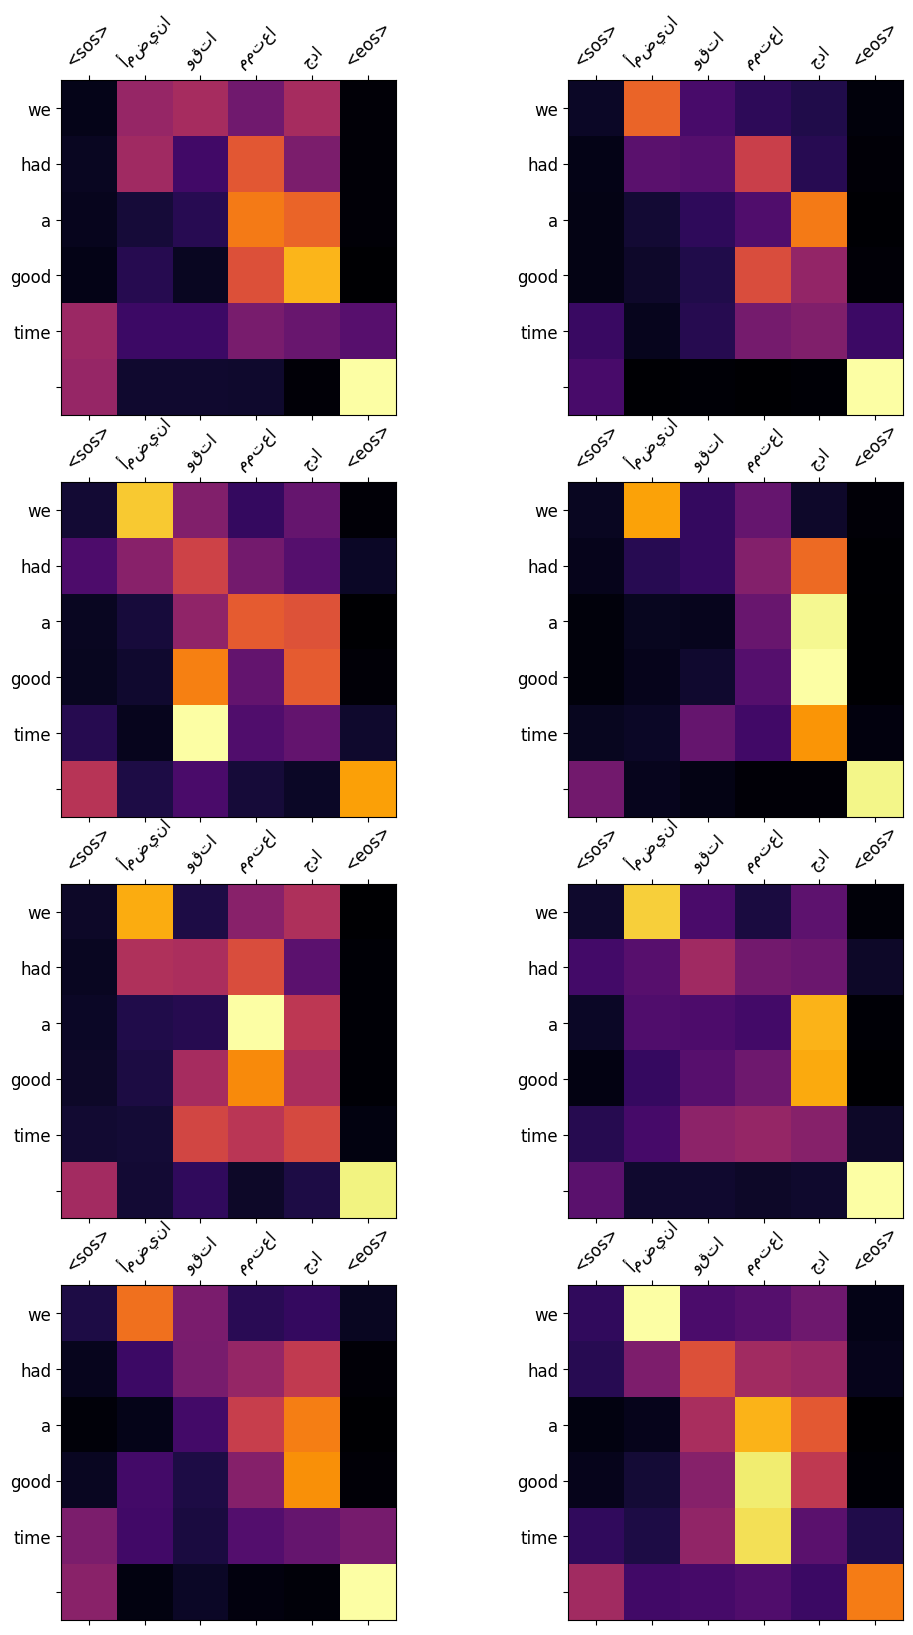

In [70]:
src = sentence.split(" ")
trg = translation.split(" ")
display_attention(src, trg, atn)